In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
from galvani import BioLogic

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
pd.set_option('display.max_rows', 1000)

## read files (csv)

In [4]:
path = '20230217_EIS_Temp_SoC'

In [45]:
# pkl_files = [path+'/'+pkl for pkl in os.listdir(path) if pkl.endswith('.pkl')]
csv_files = [path+'/'+pkl for pkl in os.listdir(path) if pkl.endswith('.csv')]
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    temp = re.search(r'Temp(\d{2})', file).group(1)
    soc = re.search(r'SoC(\d+)', file).group(1)
    
    df['temp'] = float(temp)
    df['SoC'] = float(soc)
    dfs.append(df)
    
# concat all dfs
df = pd.concat(dfs).reset_index()

In [46]:
# approaches: DF in Temperatur aufteilen (25, 60) und algorithmen anwenden
            # SoC (0 / 100)
    
# plot im Notion mit beschreibung

In [47]:
# data only 1 cycle index: 642

### remove unnecessary columns

In [48]:
# erste
df = df.drop([df.columns[0], df.columns[1], df.columns[2]], axis=1)

In [40]:
df

,cycle_Nr,Re(Z)0.00931323,-Im(Z)0.00931323,Re(Z)0.0139698,-Im(Z)0.0139698,Re(Z)0.0209548,-Im(Z)0.0209548,Re(Z)0.0325963,-Im(Z)0.0325963,Re(Z)0.0488944,...,Re(Z)4542.0,-Im(Z)4542.0,Re(Z)6740.0,-Im(Z)6740.0,Re(Z)10001.0,-Im(Z)10001.0,I(uA),SoH/%,temp,SoC
0,1.0,48852.200,46573.1000,39784.6000,41140.6000,41164.0000,38890.6000,38284.1000,33659.90000,36293.0000,...,780.6810,1205.81000,576.1290,936.67600,20.11690,672.406000,20.0,157.97,25.0,0.0
1,2.0,4262.660,744.7270,4109.6300,680.8130,3915.3400,646.5930,3753.1900,610.10900,3632.0000,...,440.6240,342.63100,352.4590,305.14300,281.64100,268.239000,20.0,174.81,25.0,0.0
2,3.0,1475.700,466.6090,1343.6600,418.3630,1274.4200,371.0910,1175.1200,330.92000,1100.9400,...,178.4680,73.80250,157.5750,72.07720,133.86400,68.948100,20.0,178.65,25.0,0.0
3,4.0,903.619,321.8030,836.9470,268.7750,776.2340,249.6110,724.8890,213.15800,679.2240,...,120.4510,46.90050,107.6450,44.27700,94.02510,41.884700,20.0,160.39,25.0,0.0
4,5.0,860.372,306.7830,787.4280,257.1490,740.4790,232.2010,687.7800,198.35700,644.6410,...,120.5290,48.66070,107.8260,45.64820,95.30070,40.905200,20.0,145.84,25.0,0.0
5,6.0,904.132,312.0500,845.3790,282.4380,790.9420,232.3320,737.3610,209.70800,690.8590,...,130.2980,55.02610,116.6830,50.25730,104.88700,46.749100,20.0,136.64,25.0,0.0
6,7.0,1005.460,336.4300,929.1020,294.2410,883.0190,262.4070,815.1520,227.07600,770.3860,...,142.7360,61.83100,127.5070,56.45790,113.24600,50.437300,20.0,128.80,25.0,0.0
7,8.0,1088.100,368.7400,1014.6200,306.3800,947.3810,282.9180,889.9140,241.01500,838.0810,...,153.5530,67.54210,136.6890,62.17340,120.77300,58.037700,20.0,122.35,25.0,0.0
8,9.0,1168.050,397.2920,1106.5800,335.7220,1026.4900,287.6070,969.6090,257.80600,911.1030,...,164.6640,74.48220,146.4870,68.00490,129.48900,59.362800,20.0,116.31,25.0,0.0
9,10.0,1222.830,413.0240,1153.0000,340.0500,1071.1500,302.0800,1017.5300,265.05500,964.1200,...,171.7910,78.97820,152.9270,71.66670,135.25900,62.880300,20.0,110.72,25.0,0.0


## Abnormal/normal aufteilung mit 3 Punkte und absolute werte

In [49]:
def divide_to_cells(df):
    # separate cells by cycle number
    df = df
    cells = []

    start = 0
    for i in df.index:
        if df['cycle_Nr'].iloc[i] > df['cycle_Nr'].shift(-1).fillna(1).iloc[i]:
            end = i+1
            cells.append(df.iloc[start:end])
            start = end

    # im and re for plotting and separating -im and re

    cells_im = []
    cells_re = []

    for cell in cells:
        im = cell[cell.columns.drop(list(cell.filter(regex='Re')))].drop('cycle_Nr', axis=1)
        cells_im.append(im)

        re = cell[cell.columns.drop(list(cell.filter(regex='Im')))].drop('cycle_Nr', axis=1)
        cells_re.append(re)
        
    
        
    return cells, cells_im, cells_re

def abnormal_index(cells, cells_im, cells_re, freqs = ['936.063', '630.738', '425.149']):
    res = []
    ims = []
    abnormal_index = []
    for count, cell in enumerate(cells):
        X = []
        Y = []
        for i in range(len(cell)):
            x = []
            y = []
            for j in freqs:
                re = 'Re(Z){}'.format(j)
                im = '-Im(Z){}'.format(j)
                x.append(cells_re[count].iloc[i][re])
                y.append(cells_im[count].iloc[i][im])
            X.append(x)
            Y.append(y)
        res.append(X)
        ims.append(Y)

    absolute = []
    for i in range(len(cells)):
        absolute.append( np.absolute( np.sqrt( np.array(np.power(res[i], 2)) + np.array(np.power(ims[i], 2) ))))

    abnormal_index = []
    a=0
    for count_out, i in enumerate(absolute):
        if len(i) == 1:
            abnormal_index.append(1)
        else:
            for count, j in enumerate(i):
                res = np.sum(np.array(i[count])) - np.sum(np.array(i[count+1]))
                if res < 0:
                    abnormal_index.append(count+1)
                    break
    return abnormal_index

In [42]:
# try 25 temp
df = df[df['temp']==25].drop('temp', axis=1)
cells, cells_im, cells_re = divide_to_cells(df)
abnormal_index = abnormal_index(cells, cells_im, cells_re)

In [50]:
# normal temp
cells, cells_im, cells_re = divide_to_cells(df)
abnormal_index = abnormal_index(cells, cells_im, cells_re)

In [51]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def multivariate_gaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

In [52]:
# methode 2
df_abnormal = pd.DataFrame(columns=df.columns)
df_normal = pd.DataFrame(columns=df.columns)
    
for count, cell in enumerate(cells):
#     for i, rows in enumerate(cell):
#         if i <= abnormal_index[count]:
#             df_abnormal.append(cell.iloc[i])
#         else:
#             df_normal.append(cell.iloc[i])
    df_abnormal = df_abnormal.append(cell.loc[cell['cycle_Nr'] <= abnormal_index[count]], ignore_index=True)
    df_normal = df_normal.append(cell.loc[cell['cycle_Nr'] > abnormal_index[count]], ignore_index=True)

df_normal = df_normal.drop('cycle_Nr', axis=1)
df_abnormal = df_abnormal.drop('cycle_Nr', axis=1)
df = df.drop('cycle_Nr', axis=1)


# log df
# df_t = np.log(df).replace(-np.Inf, 0)
# df_t_normal = np.log(df_normal).replace(-np.Inf, 0)
# df_t_abnormal = np.log(df_abnormal).replace(-np.Inf, 0)

df_t = feature_normalize(df)
df_t_normal = feature_normalize(df_normal)
df_t_abnormal = feature_normalize(df_abnormal)

#Im(Z) and Re(Z)
df_re = df[df.columns.drop(list(df.filter(regex='Im')))]
df_im = df[df.columns.drop(list(df.filter(regex='Re')))]
df_t_re = df_t[df_t.columns.drop(list(df_t.filter(regex='Im')))]
df_t_im = df_t[df_t.columns.drop(list(df_t.filter(regex='Re')))]

# Im(Z) normal/abnormal
df_im_normal = df_normal[df_normal.columns.drop(list(df_normal.filter(regex='Re')))]
df_im_abnormal = df_abnormal[df_abnormal.columns.drop(list(df_abnormal.filter(regex='Re')))]
df_im_t_normal = df_t_normal[df_t_normal.columns.drop(list(df_t_normal.filter(regex='Re')))]
df_im_t_abnormal = df_t_abnormal[df_t_abnormal.columns.drop(list(df_t_abnormal.filter(regex='Re')))]

# Re(Z) normal/abnormal
df_re_normal = df_normal[df_normal.columns.drop(list(df_normal.filter(regex='Im')))]
df_re_abnormal = df_abnormal[df_abnormal.columns.drop(list(df_abnormal.filter(regex='Im')))]
df_re_t_normal = df_t_normal[df_t_normal.columns.drop(list(df_t_normal.filter(regex='Im')))]
df_re_t_abnormal = df_t_abnormal[df_t_abnormal.columns.drop(list(df_t_abnormal.filter(regex='Im')))]

<IPython.core.display.Javascript object>


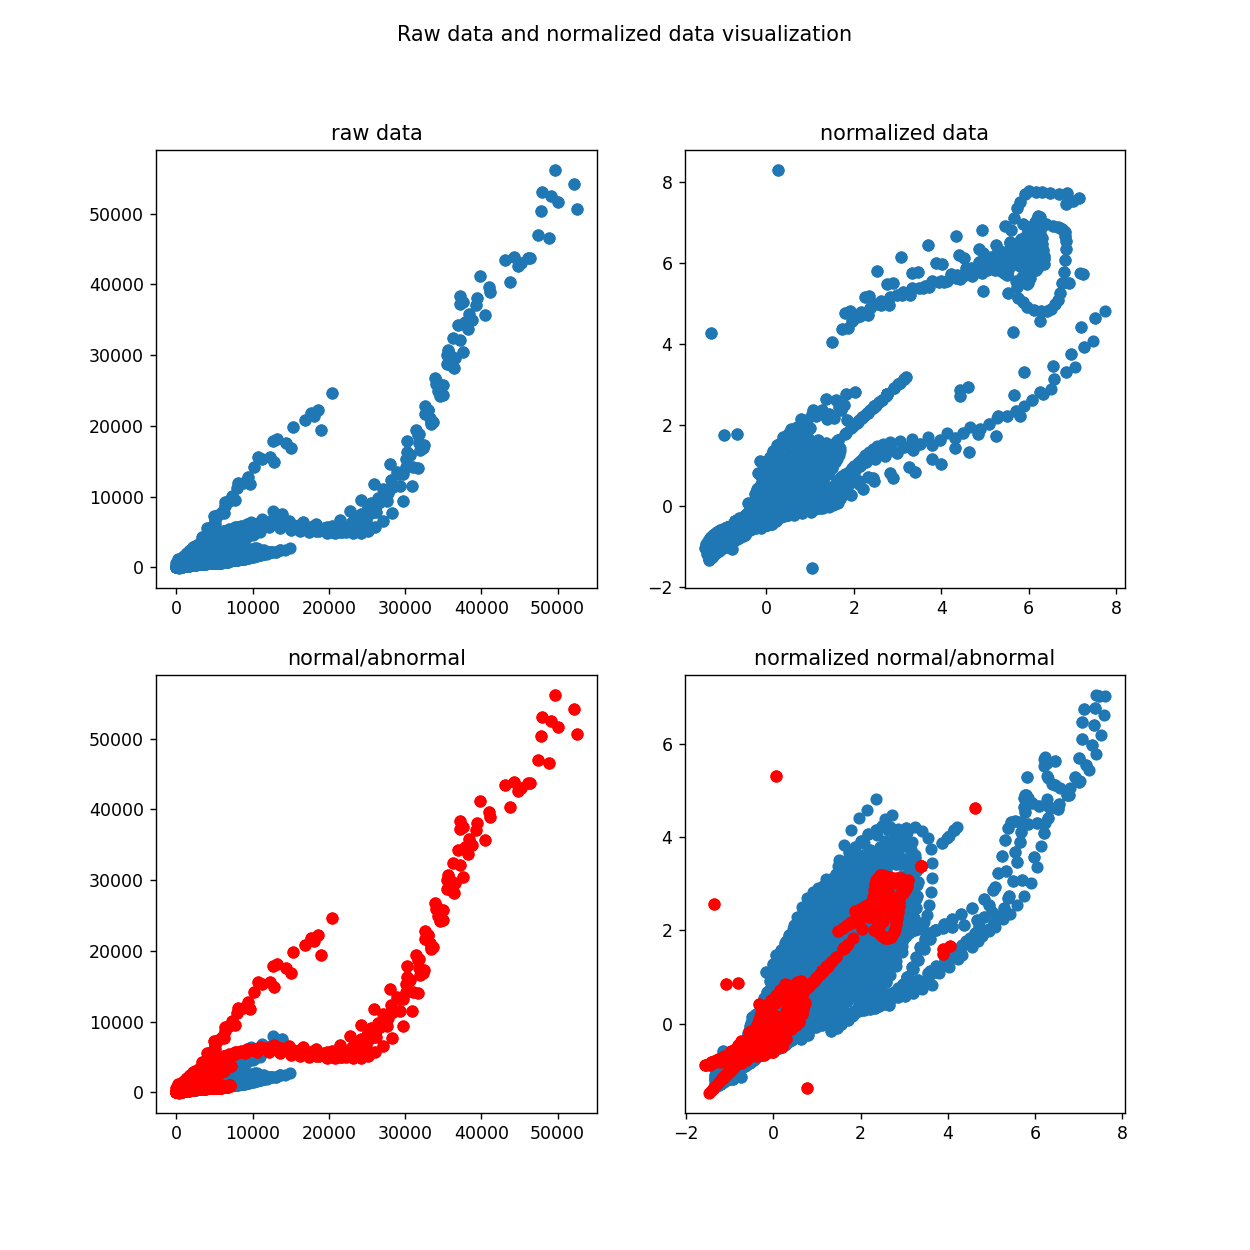

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Raw data and normalized data visualization')

axes[0][0].set_title('raw data')
axes[0][0].scatter(df_re, df_im)

axes[0][1].set_title('normalized data')
axes[0][1].scatter(df_t_re, df_t_im)

axes[1][0].set_title('normal/abnormal')
axes[1][0].scatter(df_re_normal, df_im_normal)
axes[1][0].scatter(df_re_abnormal, df_im_abnormal, c='r')

axes[1][1].set_title('normalized normal/abnormal')
axes[1][1].scatter(df_re_t_normal, df_im_t_normal)
axes[1][1].scatter(df_re_t_abnormal, df_im_t_abnormal, c='r')

plt.show()

<IPython.core.display.Javascript object>


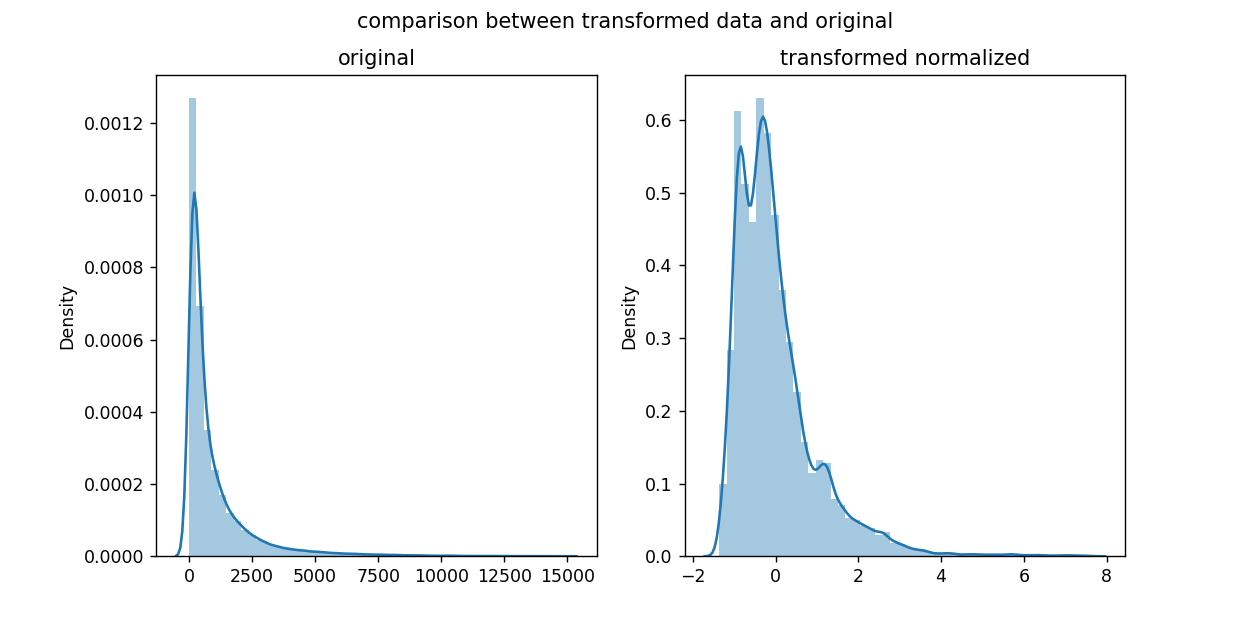

C:\Users\azhar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\azhar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [54]:
# more gaussian

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('comparison between transformed data and original')

x = df_re_normal
y = df_im_normal

axes[0].set_title('original')
sns.distplot(df_normal, ax=axes[0])

x2 = df_re_t_normal
y2 = df_im_t_normal

axes[1].set_title('transformed normalized')
sns.distplot(df_t_normal, ax=axes[1])

plt.show()

## Training

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
good_samples_train, good_samples_crv, good_samples_test = np.split(df_normal.sample(frac=1, random_state=42), 
                                                            [int(.5*len(df_t_normal)), int(.85*len(df_t_normal))])

abnormal_samples_crv, abnormal_samples_test = train_test_split(df_abnormal, test_size=0.3)


print('good samples: \n  train: {}\n  crv:    {}\n  test:  {}'.format(good_samples_train.shape, 
                                                                     good_samples_crv.shape, 
                                                                     good_samples_test.shape))
print('\nabnormal samples: \n crv: {} \n test: {}'.format(abnormal_samples_crv.shape, abnormal_samples_test.shape))

good samples: 
  train: (300, 76)
  crv:    (210, 76)
  test:  (91, 76)

abnormal samples: 
 crv: (86, 76) 
 test: (38, 76)


In [28]:
# probability using multivariate normal probability distribution function
from scipy.stats import multivariate_normal


def probability(df, colname='P(X)'):
    # mean, covariance matrix
    mean = df.mean()
    cov_matrix = np.cov(df.T)
    
    
    var = multivariate_normal.logpdf(np.array(df), mean=mean, cov=cov_matrix, allow_singular=True)
    
    # return probability
    return pd.DataFrame(var, columns=[colname])

In [29]:
good_p = probability(good_samples_train)

In [30]:
# label of normal/abnormal, normal = 0, abnormal = 1 based on abnormal cycle number above

label_good = pd.DataFrame(0, index=good_samples_crv.index, columns=['normal/abnormal'])
label_abnormal = pd.DataFrame(1, index=abnormal_samples_crv.index, columns=['normal/abnormal'])
print('abnormal samples shape: {}\nnormal samples shape: {}'.format(abnormal_samples_crv.shape, good_samples_crv.shape))

# combine the two
dfs = [abnormal_samples_crv, good_samples_crv]
labels = [label_abnormal, label_good]
crv = pd.concat(dfs)
crv_label = pd.concat(labels)

# random num to randomize the index (applies to both label and samples)
idx = np.random.permutation(crv.index)
crv = crv.loc[idx]
crv_label = crv_label.loc[idx]

# cross validation probability
crv_p = probability(crv, 'P2(X)')
crv_label = np.array(crv_label)
crv['normal/abnormal'] = crv_label
crv = crv[['normal/abnormal']+list(crv.columns.drop('normal/abnormal'))]


print('cross validation shape: {}'.format(crv_p.shape))

abnormal samples shape: (86, 76)
normal samples shape: (210, 76)
cross validation shape: (346, 1)


# find epsilon

In [31]:
# Alg 1
def select_threshold(probs, test_data):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs), max(probs), stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(test_data, predictions, average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon

    return best_f1, best_epsilon

In [32]:
# function to calculate true positives, false positives, and false negatives

def tpfpfn(ep, p):
    tp, fp, fn = 0, 0, 0
    for i in range(len(crv_label)):
        if p[i] <= ep and crv_label[i][0] == 1:
            tp += 1
        elif p[i] <= ep and crv_label[i][0] == 0:
            fp += 1
        elif p[i] > ep and crv_label[i][0] == 1:
            fn += 1
    return tp, fp, fn

# function calculate f1 score

def f1(ep, p):
    try:
        tp, fp, fn = tpfpfn(ep, p)
        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        f1 = 2*prec*rec/(prec + rec)
    except ZeroDivisionError:
        f1 = 0
    return f1

# returns a list of labels where anomaly = 1 and 0 otherwise
def detect_anomaly(df, ep):
    # test probability
    # label each with 1 if probability is smaller than epsilon
    df_t = df
    df_p = np.array(probability(df))
    label = []
    for i in range(len(df_t)):
        if np.array(df_p)[i] <= ep:
            label.append(1)
        else:
            label.append(0)
    return label

# plot
def graph_anom(df_anomaly):
    df_im_anomaly = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Re')))].loc[df_anomaly['label'] == 1]
    df_im_good = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Re')))].loc[df_anomaly['label'] == 0]
    df_re_anomaly = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Im')))].loc[df_anomaly['label'] == 1]
    df_re_good = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Im')))].loc[df_anomaly['label'] == 0]
    
    plt.title("Anomalies")
    
    plt.scatter(df_re_anomaly, df_im_anomaly, c='red', label='anomaly') # re and -im
    plt.scatter(df_re_good, df_im_good, label='good')
    plt.xlabel('Re')
    plt.ylabel('-Im')
    plt.legend()
    plt.show()

In [33]:
# epsilon

# current selected threshold is the mean of cross validation probability
threshold = crv_p.mean()[0]

epsilon = []
for i in np.array(crv_p):
    ep = i[0]
    if ep <= threshold and ep != 0:
        epsilon.append(ep)

# find the f1 score for each epsilon and probability

f = []
for i in epsilon:
    f.append(f1(i, np.array(crv_p)))
    
# epsilon variable to use for all anomaly measurement
e = epsilon[np.array(f).argmax()]
print('epsilon: {}'.format(e))

epsilon: -206.7458548972088


## Result

### Ergebnis mit SoH Aufteilung

<IPython.core.display.Javascript object>


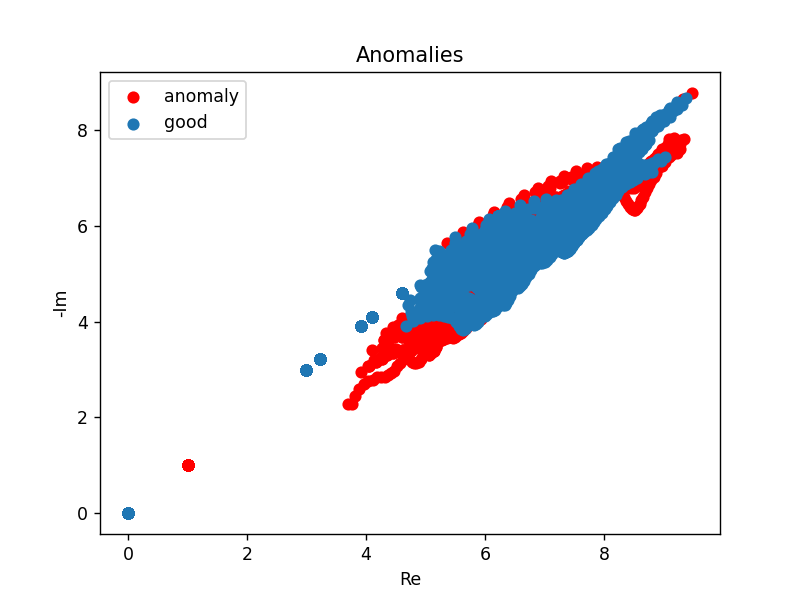

In [32]:
# anomaly detection with test data

dfs_test = [abnormal_samples_test, good_samples_test]
df_test = pd.concat(dfs_test)

# parameter: test dataframe and epsilon
df_test['label'] = detect_anomaly(df_test, e)
graph_anom(df_test)

## Ergebnis mit verteilung der Graphen Absolut Werte (Temp 25)

<IPython.core.display.Javascript object>


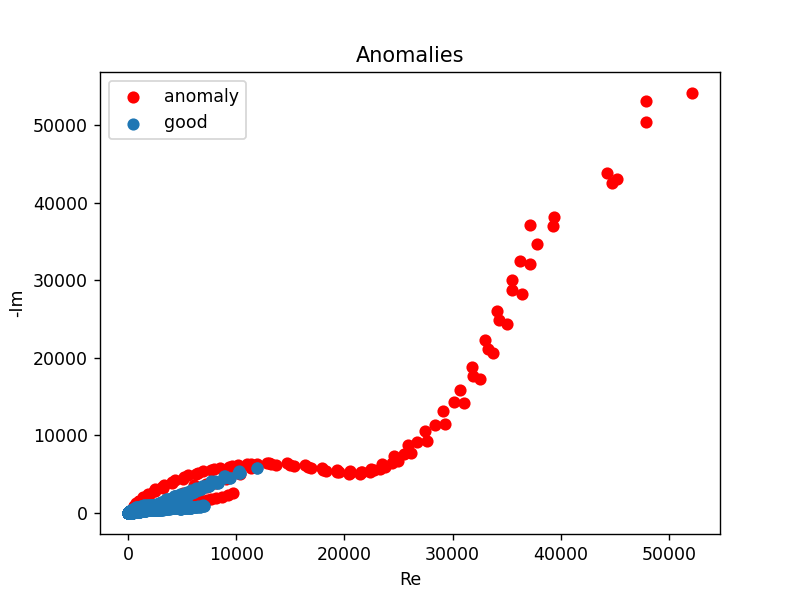

In [28]:
# not tried yet
dfs_test = [abnormal_samples_test, good_samples_test]
df_test = pd.concat(dfs_test)

# parameter: test dataframe and epsilon
df_test['label'] = detect_anomaly(df_test, e)
graph_anom(df_test)

<IPython.core.display.Javascript object>


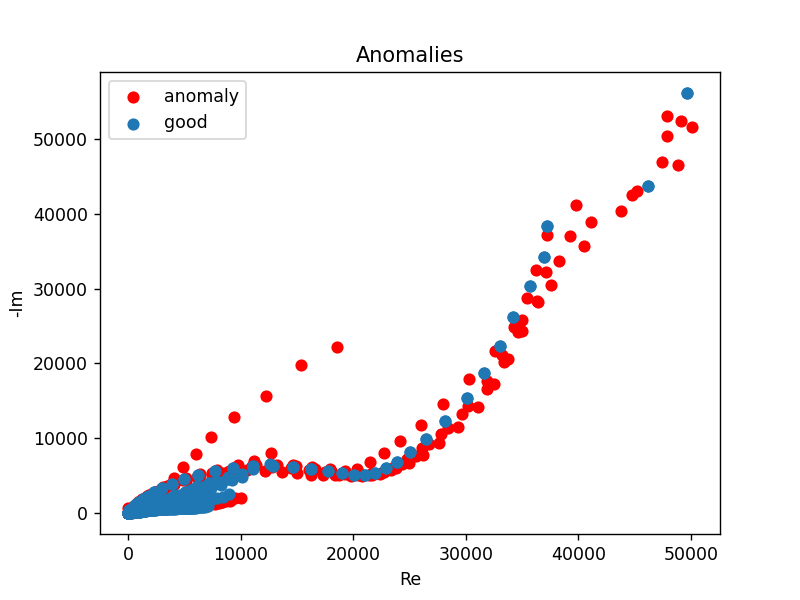

In [34]:
dfs_test = [abnormal_samples_test, good_samples_test]
df_test = pd.concat(dfs_test)

# parameter: test dataframe and epsilon
df_test['label'] = detect_anomaly(df_test, e)
graph_anom(df_test)